In [98]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.mlab as mlab
from scipy.stats import norm
import math

import datetime
import copy
from enum import Enum
from operator import add

In [2]:
%matplotlib inline

In [3]:
class Day(Enum):
    SUN = "Sunday"
    MON = "Monday"
    TUE = "Tuesday"
    WED = "Wednesday"
    THU = "Thursday"
    FRI = "Friday"
    SAT = "Saturday"
    
class Week(Enum):
    FULL = [Day.SUN, Day.MON, Day.TUE, Day.WED, Day.THU, Day.FRI, Day.SAT]
    WORK = [Day.MON, Day.TUE, Day.WED, Day.THU, Day.FRI]

    def days(self):
        return self.value
    
    def day_names(self):
        return list(map(lambda day: day.value, self.value))

class Project(Enum):
    UPLINK = "Uplink"
    SKINIO = "SkinIO"
    TRUMPET = "Trumpet"
    ALEXANDRIA = "Alexandria"
    QUEST = "Quest"
    SCINTILLOMETER = "Scintillometer"
    WEDDING_WEBSITE = "Wedding Website"
    OTHER = "Other"
    
    def is_job(self):
        return self == Project.SKINIO

    def is_side_project(self):
        return self in [
            Project.UPLINK,
            Project.ALEXANDRIA,
            Project.QUEST,
            Project.SCINTILLOMETER,
            Project.WEDDING_WEBSITE
        ]
    
    def is_work(self):
        return self.is_job() or self.is_side_project()
    
    @staticmethod
    def get_from(project, task):
        if (project == "Uplink"):
            return Project.UPLINK
        elif (task == "SkinIO"):
            return Project.SKINIO
        elif (project == "Trumpet"):
            return Project.TRUMPET
        elif (project == "Alexandria"):
            return Project.ALEXANDRIA
        elif (project == "Quest"):
            return Project.QUEST
        elif (project == "Scintillometer"):
            return Project.SCINTILLOMETER
        elif (project == "Wedding Website"):
            return Project.WEDDING_WEBSITE
        else:
            return Project.OTHER
    
    @staticmethod
    def jobs():
        return list(filter(lambda project: project.is_job(), Project.all()))

    @staticmethod
    def side_projects():
        return list(filter(lambda project: project.is_side_project(), Project.all()))
    
    def work():
        return list(filter(lambda project: project.is_work(), Project.all()))
    
    @staticmethod
    def all():
        return [
            Project.UPLINK,
            Project.SKINIO,
            Project.TRUMPET,
            Project.ALEXANDRIA,
            Project.QUEST,
            Project.SCINTILLOMETER,
            Project.WEDDING_WEBSITE,
            Project.OTHER
        ]

class Key(Enum):
    DATE = "date"
    DAY = "day"
    PROJECT = "project"
    START = "start"
    END = "end"
    AMOUNT = "amount"

FILENAME = '2017-Records.csv'

In [4]:
class Entry:
    def __init__(self, date, day, project, start, end, amount):
        self.date = date
        self.day = day
        self.project = project
        self.start = start
        self.end = end
        self.amount = amount

def read_data(name=FILENAME):
    data = pd.read_csv(name)
    return data

def reformat_data(data):
    columns = list(data.columns.values)

    date_index = columns.index("date")
    day_index = columns.index("day")
    
    project_index = columns.index("project")
    task_index = columns.index("task")
    
    start_index = columns.index("start")
    end_index = columns.index("end")
    
    amount_index = columns.index("amount_decimal")
    
    formatted = []
    for row in data.values:
        date = row[date_index]
        day = Day(row[day_index])
        
        project_raw = row[project_index]
        task_raw = row[task_index]
        project = Project.get_from(project_raw, task_raw)
        
        start = row[start_index]
        end = row[end_index]
        
        amount = row[amount_index]
        
        entry = Entry(date, day, project, start, end, amount)
        
        formatted.append(entry)
    return formatted

def get_data():
    return reformat_data(read_data())

def get_by_project(project):
    data = get_data()
    return list(filter(lambda entry: entry.project == project, data))

In [5]:
def get_working_hours(filter=None, groups_per_hour = 12):
    data = get_data if filter == None else get_by_project(filter)
    complete_data = {
        Day.SUN: [0]*(24*groups_per_hour),
        Day.MON: [0]*(24*groups_per_hour),
        Day.TUE: [0]*(24*groups_per_hour),
        Day.WED: [0]*(24*groups_per_hour),
        Day.THU: [0]*(24*groups_per_hour),
        Day.FRI: [0]*(24*groups_per_hour),
        Day.SAT: [0]*(24*groups_per_hour),
    }
    
    for entry in data:
        start_time = datetime.datetime.strptime(entry.start, '%I:%M %p')
        end_time = datetime.datetime.strptime(entry.end, '%I:%M %p')

        start_time_index = start_time.hour * groups_per_hour + round(start_time.minute/(60/groups_per_hour))
        end_time_index = end_time.hour * groups_per_hour + round(end_time.minute/(60/groups_per_hour))
            
        for time_index in range(start_time_index, end_time_index + 1):
            complete_data[entry.day][time_index] += 1
    return complete_data

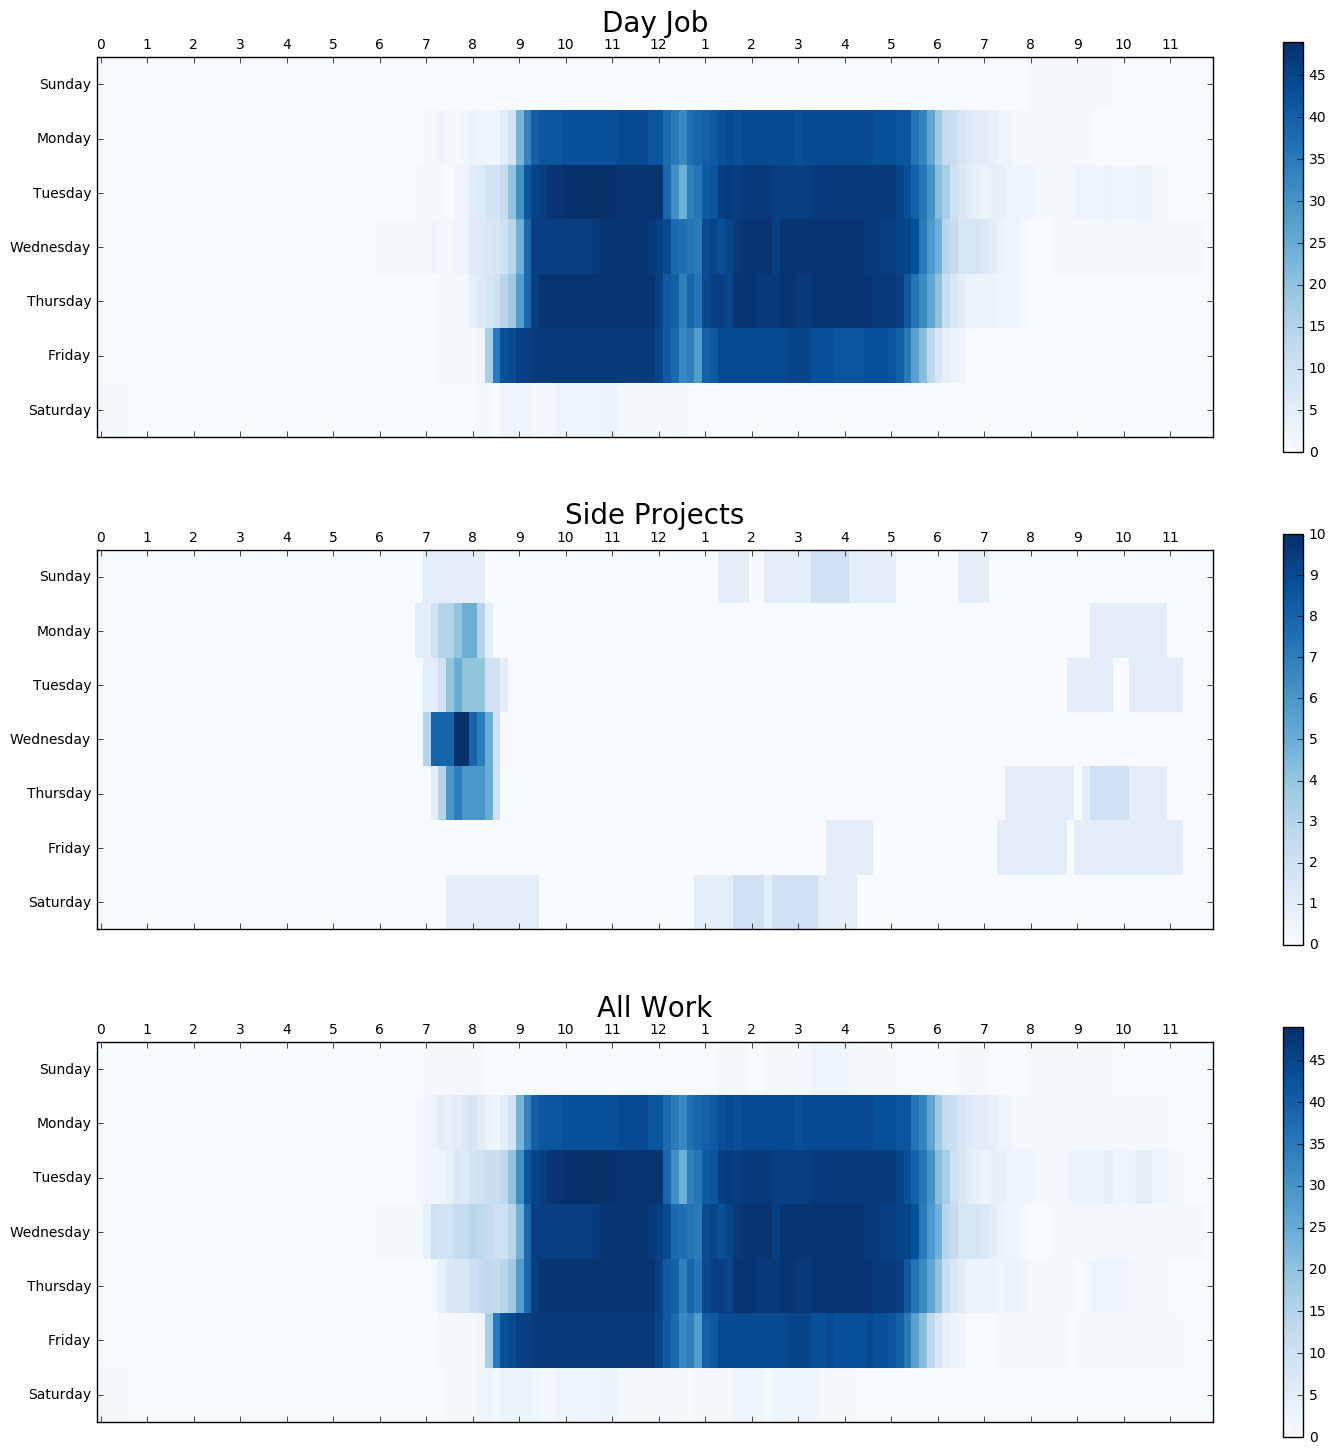

In [6]:
WEEK_TYPE = Week.FULL
# GROUPS_PER_HOUR must be >= 2
GROUPS_PER_HOUR = 6

working_hours = {}
for project in Project:
    working_hours[project] = get_working_hours(project, GROUPS_PER_HOUR)

# matshow displays matrices in their native ratio. To get this to display well, the data will
# be padded. That will make each cell rectangular, but will make interpretation of the graph
# much easier. SkinIO is used as a seed, but any project could be used

target_ratio = 3
time_length = len(working_hours[Project.SKINIO][Day.MON])
days_length = len(WEEK_TYPE.days())
current_ratio = time_length/days_length
padding_scaler = round(current_ratio/target_ratio)

# Project Specific Data

display_data = {}
for key in working_hours:
    display_data[key] = []
    for day in WEEK_TYPE.days():
        for _ in range(padding_scaler if padding_scaler > 0 else 1):
            display_data[key].append(working_hours[key][day])
            
# Shared Data

ticker_locations = [round(padding_scaler / 2) - 1]
while (ticker_locations[-1] + padding_scaler) < len(display_data[Project.SKINIO]):
    ticker_locations.append(ticker_locations[-1] + padding_scaler)

time_labels = list(map(lambda label: (label if label <= 12 else label - 12), range(24)))

# Regroup Display Data

def create_merged(filters):
    result = None
    for filter in filters:
        if (result == None):
            result = copy.deepcopy(display_data[filter])
        else:
            for index in range(0, len(result)):
                result[index] = list(map(add, result[index], display_data[filter][index]))
    return result

day_job = create_merged(Project.jobs())
side_projects = create_merged(Project.side_projects())
all_work = create_merged(Project.work())

# Graph Results

fig = plt.figure(figsize=(18, 18))

ax = fig.add_subplot(311)
ax.set_title("Day Job", fontsize=20)
cax = ax.matshow(day_job, interpolation='nearest', cmap='Blues')
fig.colorbar(cax, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(GROUPS_PER_HOUR))
ax.yaxis.set_major_locator(ticker.FixedLocator(ticker_locations))
ax.set_xticklabels([''] + list(time_labels))
ax.set_yticklabels(list(WEEK_TYPE.day_names()))

ay = fig.add_subplot(312)
ay.set_title("Side Projects", fontsize=20)
cay = ay.matshow(side_projects, interpolation='nearest', cmap='Blues')
fig.colorbar(cay, ax=ay)
ay.xaxis.set_major_locator(ticker.MultipleLocator(GROUPS_PER_HOUR))
ay.yaxis.set_major_locator(ticker.FixedLocator(ticker_locations))
ay.set_xticklabels([''] + list(time_labels))
ay.set_yticklabels(list(WEEK_TYPE.day_names()))

az = fig.add_subplot(313)
az.set_title("All Work", fontsize=20)
caz = az.matshow(all_work, interpolation='nearest', cmap='Blues')
fig.colorbar(caz, ax=az)
az.xaxis.set_major_locator(ticker.MultipleLocator(GROUPS_PER_HOUR))
az.yaxis.set_major_locator(ticker.FixedLocator(ticker_locations))
az.set_xticklabels([''] + list(time_labels))
az.set_yticklabels(list(WEEK_TYPE.day_names()))

plt.show()

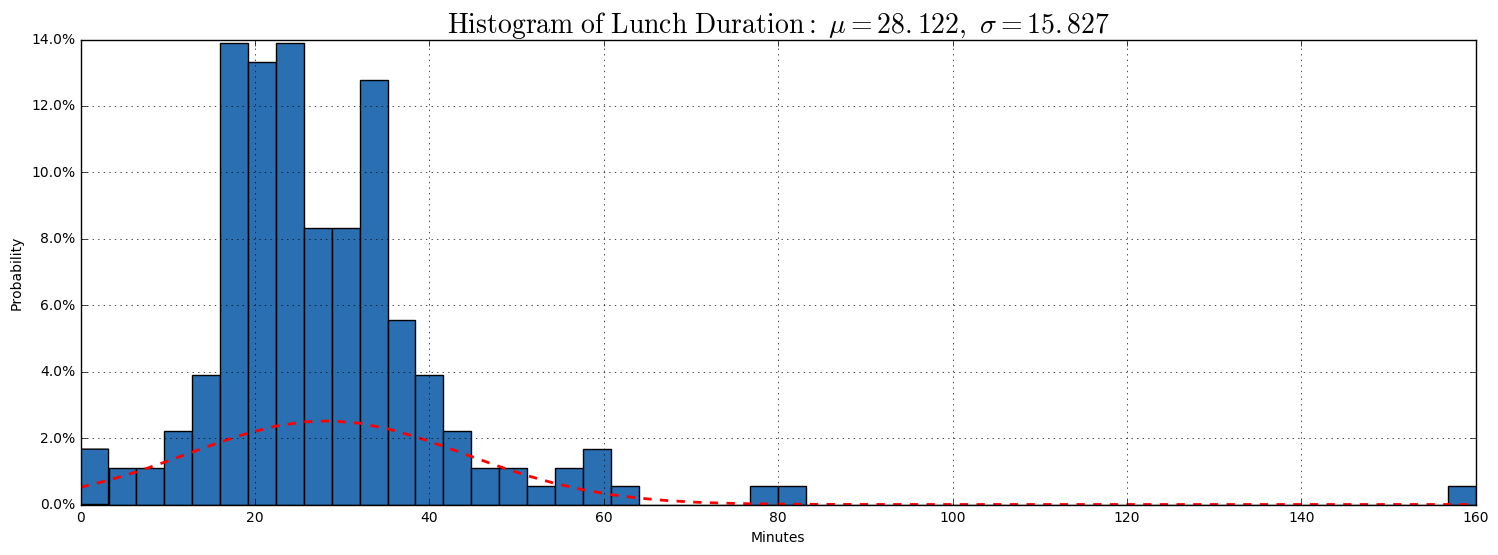

In [7]:
def calculate_lunch():
    # Get all working entries
    data = get_by_project(Project.SKINIO)

    # Filter weekend entries
    data = list(filter(lambda entry: entry.day in Week.WORK.value, data))
    
    # Group by Date
    data_by_date = {}
    for entry in data:
        if not entry.date in data_by_date:
            data_by_date[entry.date] = []
        data_by_date[entry.date].append(entry)
        
    # Calculate Lunch
    lunch_duration = []
    for date in data_by_date:
        day_data = data_by_date[date]
        entries = len(day_data)
        if (entries == 1):
            # Filter very short days (half days)
            if (entry.amount > 6):
                lunch_duration.append(0)
        elif (entries == 2):
            start_time = datetime.datetime.strptime(day_data[0].end, '%I:%M %p')
            end_time = datetime.datetime.strptime(day_data[1].start, '%I:%M %p')

            if (end_time.hour > 14):
                lunch_duration.append(0)
                continue
            
            delta = end_time - start_time
            duration = delta.seconds / 60
            lunch_duration.append(duration)
        else:
            # These entries are more complicated.
            # This means I worked in the morning, evening, or took another break.
            # Ignoring for now.
            continue
        
    return lunch_duration

def to_percent(y, position):
    s = str(100 * y)
    return s + '%'
            
lunch = calculate_lunch()
(mu, sigma) = norm.fit(lunch)

fig = plt.figure(figsize=(18, 6))

weights = np.ones_like(lunch)/float(len(lunch))
n, bins, patches = plt.hist(lunch, 50, facecolor=(42/255.0, 111/255.0, 177/255.0, 1), weights=weights)

y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel('Minutes')
plt.ylabel('Probability')
plt.title('$\mathrm{Histogram\ of\ Lunch\ Duration:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma), fontsize=20)
plt.grid(True)

formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

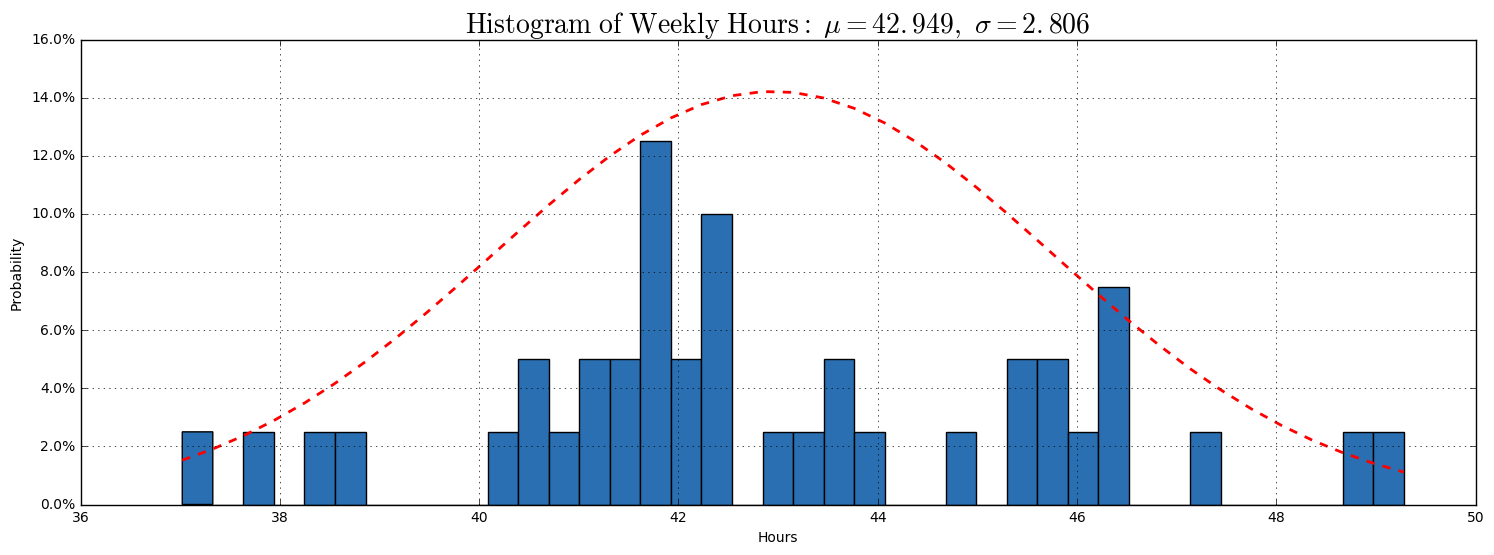

In [85]:
def calculate_composite_hours(project):
    data = get_by_project(project)
    
    composite_data = {}
    for entry in data:
        date = datetime.datetime.strptime(entry.date, '%m/%d/%y')
        cal = date.isocalendar()
        
        week = cal[1]
        day = date.day
        
        if (week == 21):
            continue

        if (week not in composite_data):
            composite_data[week] = {}
        if (day not in composite_data[week]):
            composite_data[week][day] = 0.0
            
        composite_data[week][day] += entry.amount
    
    return composite_data

def filter_incomplete_weeks(data):
    filtered_data = {}
    
    for week in data:
        working_days = len(data[week])
        if (working_days >= 5):
            filtered_data[week] = data[week]
    return filtered_data

def flatten_weeks(data):
    flattened_data = {}
    for week in data:
        hours_per_day = list(map(lambda day: data[week][day], data[week]))
        flattened_data[week] = sum(hours_per_day)
    return flattened_data

composite_hours = calculate_composite_hours(Project.SKINIO)
complete_weeks = filter_incomplete_weeks(composite_hours)
summed_weeks = flatten_weeks(complete_weeks)
hours = list(summed_weeks.values())

(mu, sigma) = norm.fit(hours)

fig = plt.figure(figsize=(18, 6))

weights = np.ones_like(hours)/float(len(hours))
n, bins, patches = plt.hist(hours, 40, facecolor=(42/255.0, 111/255.0, 177/255.0, 1), weights=weights)

y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel('Hours')
plt.ylabel('Probability')
plt.title('$\mathrm{Histogram\ of\ Weekly\ Hours:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma), fontsize=20)
plt.grid(True)

formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

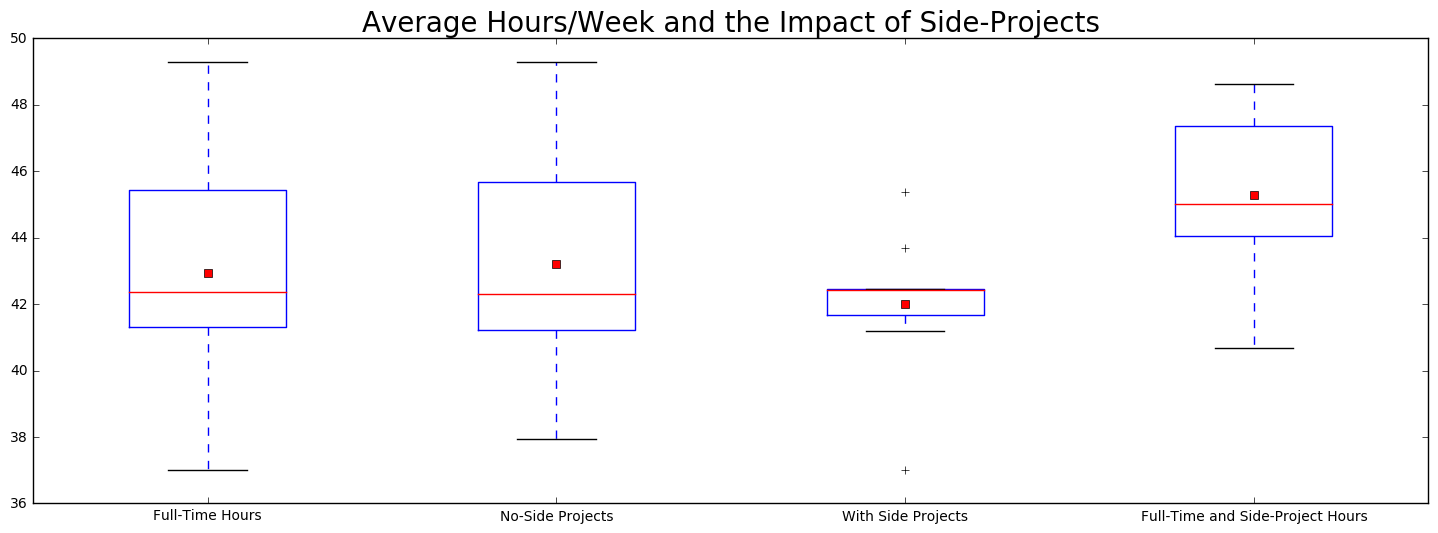

In [135]:
# Calculate All Side Project Data
side_project_data = {}
for project in Project.side_projects():
    project_hours = calculate_composite_hours(project)
    flattened_hours = flatten_weeks(project_hours)
    side_project_data[project] = flattened_hours
week_names = list(complete_weeks.keys())

# Merge side project data, filtering by complete full-time weeks
side_project_hours_per_week = {}
for project in side_project_data:
    for week in side_project_data[project]:
        if week not in week_names:
            continue
        if week not in side_project_hours_per_week:
            side_project_hours_per_week[week] = 0.0

        side_project_hours_per_week[week] += side_project_data[project][week]
side_project_week_names = list(side_project_hours_per_week.keys())
side_project_hours = list(side_project_hours_per_week.values())

# Create Overlapping and Totals Groups
overlapping_hours_by_week = {}
total_when_overlapping_by_week = {}
for week in side_project_week_names:
    overlapping_hours_by_week[week] = summed_weeks[week]
    total_when_overlapping_by_week[week] = summed_weeks[week] + side_project_hours_per_week[week]

overlapping_hours = list(overlapping_hours_by_week.values())
total_when_overlapping = list(total_when_overlapping_by_week.values())

# Create Non-Overlapping Group
non_overlapping_hours_by_week = {}
for week in week_names:
    if week in side_project_week_names:
        continue
    non_overlapping_hours_by_week[week] = summed_weeks[week]
non_overlapping_hours = list(non_overlapping_hours_by_week.values())

# Graph Results
fig = plt.figure(figsize=(18, 6))

hours_box_data = [
    hours,
    non_overlapping_hours,
    overlapping_hours,
    total_when_overlapping
]
hours_box_data_labels = [
    "Full-Time Hours",
    "No-Side Projects",
    "With Side Projects",
    "Full-Time and Side-Project Hours"
]

ax = fig.add_subplot(111)
ax.set_title("Average Hours/Week and the Impact of Side-Projects", fontsize=20)
ax.boxplot(hours_box_data, showmeans=True, labels=hours_box_data_labels)

plt.show()

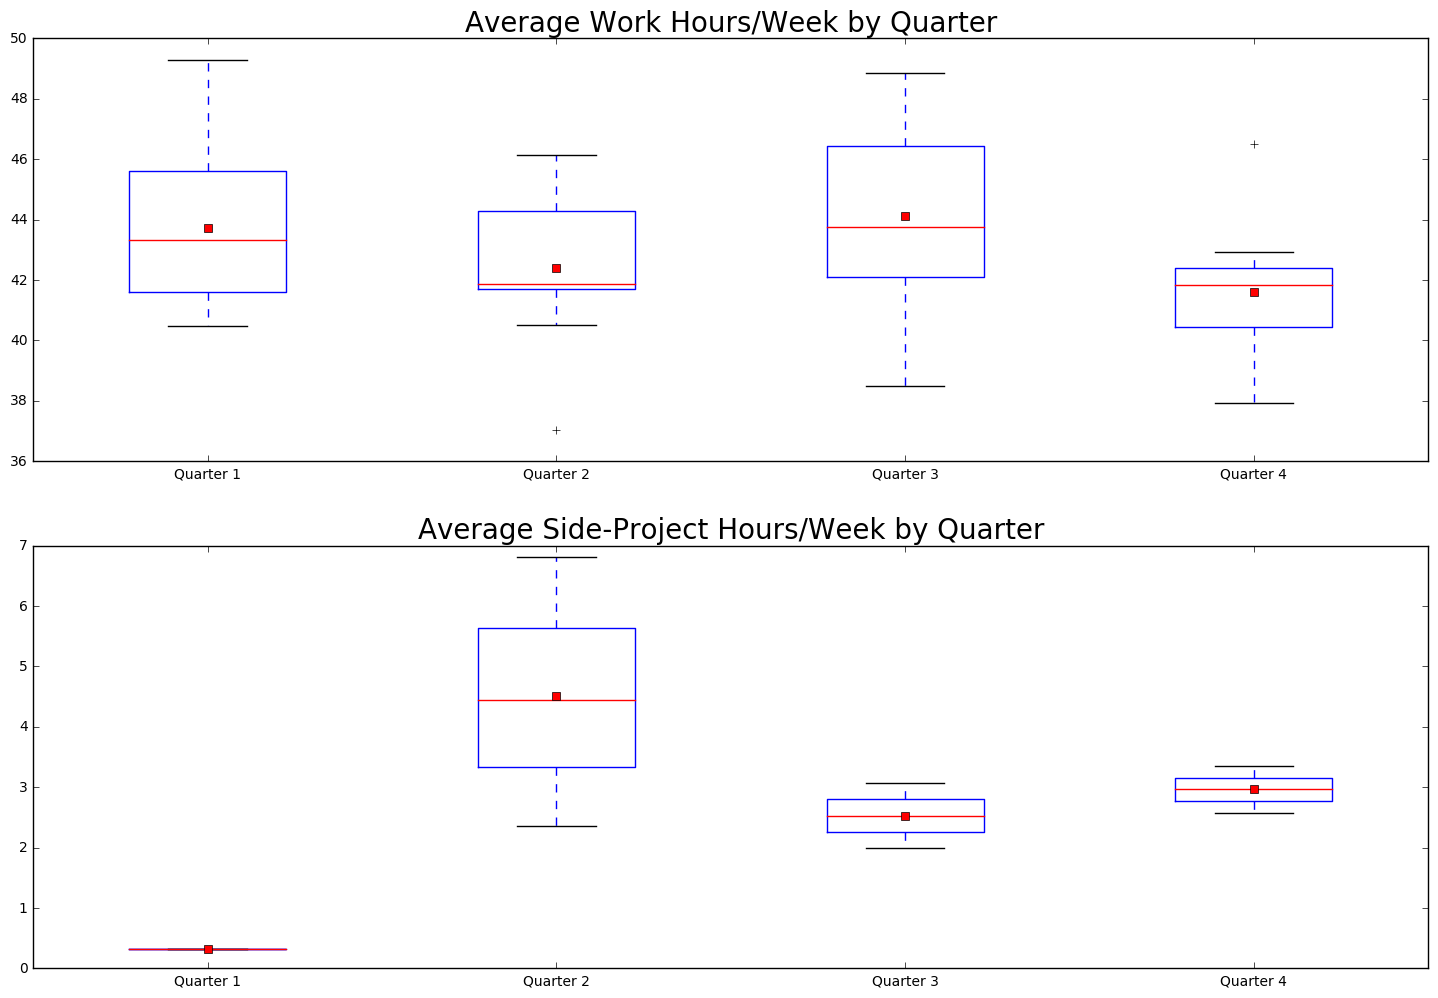

In [132]:
complete_weeks_by_quarter = {}
for week in summed_weeks:
    quarter = math.ceil(week/13.0)
    if quarter not in complete_weeks_by_quarter:
        complete_weeks_by_quarter[quarter] = []
    complete_weeks_by_quarter[quarter].append(summed_weeks[week])
    
complete_side_project_weeks_by_quarter = {}
for week in side_project_hours_per_week:
    quarter = math.ceil(week/13.0)
    if quarter not in complete_side_project_weeks_by_quarter:
        complete_side_project_weeks_by_quarter[quarter] = []
    complete_side_project_weeks_by_quarter[quarter].append(side_project_hours_per_week[week])

# Arrange Data for Graphing
    
quarters = list(complete_weeks_by_quarter.keys())
list.sort(quarters)

quarters_box_data = []
for quarter in quarters:
    quarters_box_data.append(complete_weeks_by_quarter[quarter])
    
quarters_side_project_box_data = []
for quarter in quarters:
    quarters_side_project_box_data.append(complete_side_project_weeks_by_quarter[quarter])

# Graph Results
fig = plt.figure(figsize=(18, 12))

quarters_box_data_labels = list(map(lambda quarter: "Quarter " + str(quarter), quarters))

ax = fig.add_subplot(211)
ax.set_title("Average Work Hours/Week by Quarter", fontsize=20)
ax.boxplot(quarters_box_data, showmeans=True, labels=quarters_box_data_labels)

ay = fig.add_subplot(212)
ay.set_title("Average Side-Project Hours/Week by Quarter", fontsize=20)
ay.boxplot(quarters_side_project_box_data, showmeans=True, labels=quarters_box_data_labels)

plt.show()

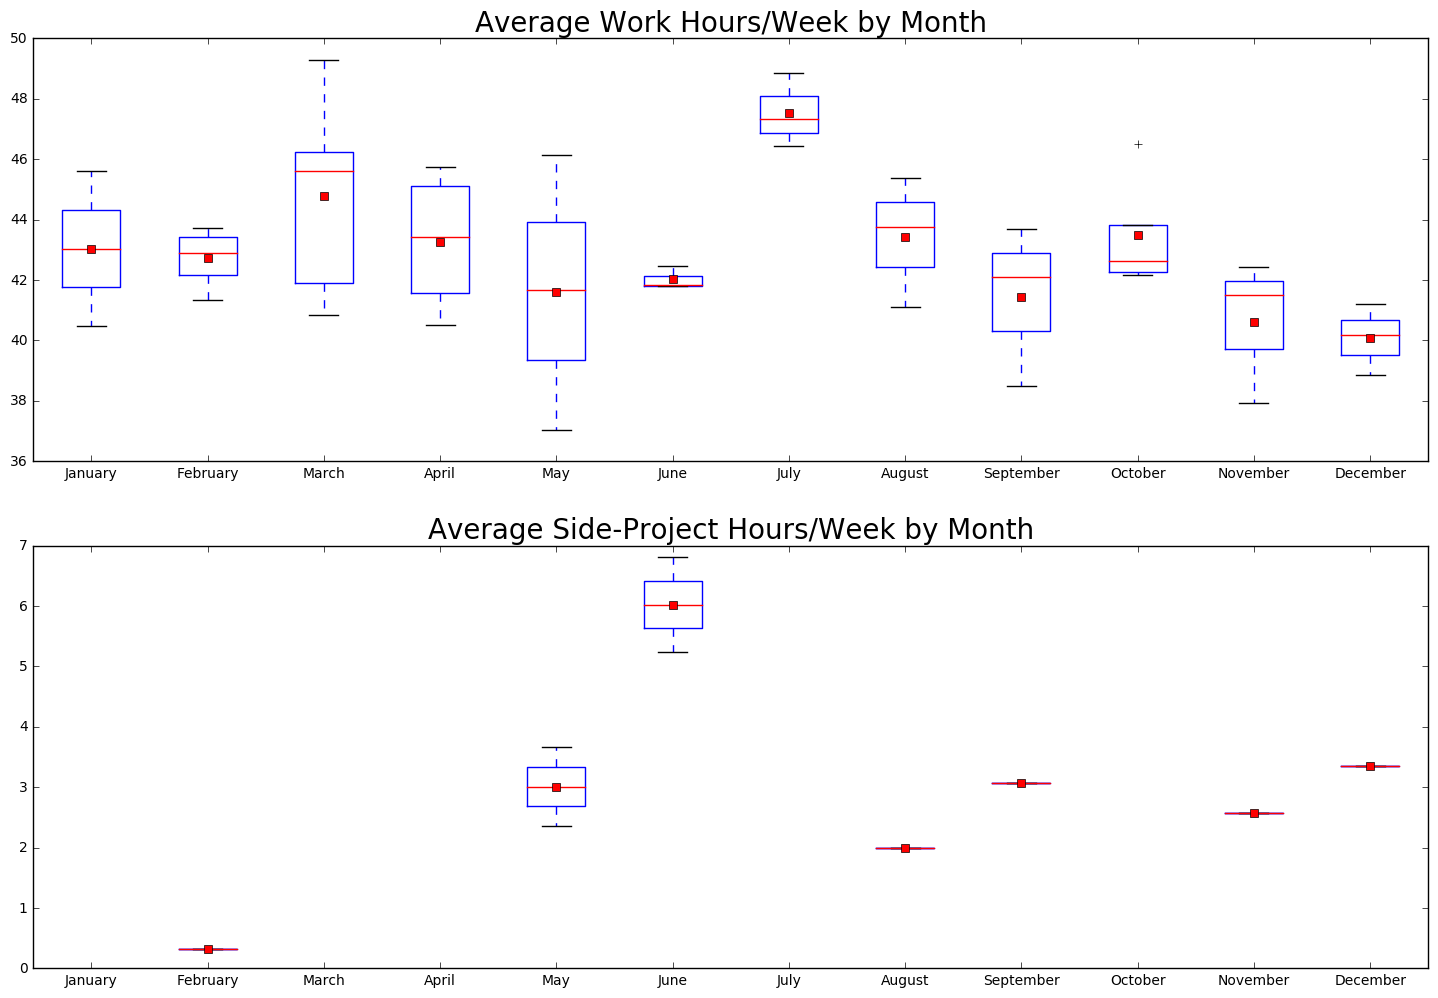

In [133]:
complete_weeks_by_month = {}
for week in summed_weeks:
    month = math.ceil(week/4.3334)
    if month not in complete_weeks_by_month:
        complete_weeks_by_month[month] = []
    complete_weeks_by_month[month].append(summed_weeks[week])
    
complete_side_project_weeks_by_month = {}
for week in side_project_hours_per_week:
    month = math.ceil(week/4.3334)
    if month not in complete_side_project_weeks_by_month:
        complete_side_project_weeks_by_month[month] = []
    complete_side_project_weeks_by_month[month].append(side_project_hours_per_week[week])

# Arrange Data for Graphing
    
months = range(1,13)

months_box_data = []
for month in months:
    months_box_data.append(complete_weeks_by_month[month])
    
months_side_project_box_data = []
for month in months:
    if month in complete_side_project_weeks_by_month:
        months_side_project_box_data.append(complete_side_project_weeks_by_month[month])
    else:
        months_side_project_box_data.append([])

by_month_labels = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]
        
# Graph Results
fig = plt.figure(figsize=(18, 12))

ax = fig.add_subplot(211)
ax.set_title("Average Work Hours/Week by Month", fontsize=20)
ax.boxplot(months_box_data, showmeans=True, labels=by_month_labels)

ay = fig.add_subplot(212)
ay.set_title("Average Side-Project Hours/Week by Month", fontsize=20)
ay.boxplot(months_side_project_box_data, showmeans=True, labels=by_month_labels)

plt.show()